In [584]:
import os, sys

import pymongo as pm
import numpy as np
import scipy.stats as stats
import math
import pandas as pd
import json
import re
from io import BytesIO
from PIL import Image
import requests # this is to access the stim urls from the notebook
from IPython.display import SVG, display # need for showing stims with sketches side by side
import base64
import PIL

import matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.patches as mpatches
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
from matplotlib import rcParams
matplotlib.rcParams['pdf.fonttype'] = 42

import colorsys # for doing colours right when we plot lots of datz

from IPython.display import clear_output
import importlib

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

# so dataframes don't get cut off in display:
pd.set_option("display.max_rows", None, "display.max_columns", None)


### establish connection to mongo
first thing you need to do is to establish an ssh tunnel (aka remote port forwarding) to the server, so that requests to the mongodb can be made "as if" the mongodb server is running on your local computer. Run this from the command line before you begin data analysis if you plan to fetch data from mongo:

ssh -fNL 27020:127.0.0.1:27017 USER@cogtoolslab.org

In [585]:
! ssh -fNL 27020:127.0.0.1:27017 sholt@cogtoolslab.org

In [687]:
# set vars 
auth = pd.read_csv(os.path.join(os.getcwd(),'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
import socket
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1:27017')
db = conn['iterated_number']
coll = db['dots1']

# which iteration name(s) should we use?
iterationName = 'pilot4'  # 'sandbox', 'pilot1' is crap, 'pilot2' still isn't saving demographic surveys

# coll.remove({'iterationName':'sandbox'})

# see how many different people have taken our experiment on Prolific
print("Total {} Senders".format(len(coll.find({'iterationName':iterationName,'eventType':'newSymbols'}).distinct('prolificID'))))
print("Total {} Receivers".format(len(coll.find({'iterationName':iterationName,'eventType':'clickedObj'}).distinct('prolificID'))))
print("Total {} Surveys".format(len(coll.find({'iterationName':iterationName,'eventType':'posttestSurvey'}).distinct('prolificID'))))

# print("")
# pd.DataFrame(coll.find({'iterationName':iterationName,'eventType':'posttestSurvey'}))#['surveyData'][0][4]

Total 5 Senders
Total 4 Receivers
Total 8 Surveys


In [689]:
# get the dataframe of symbols that were made
s = coll.find({'iterationName':iterationName,'eventType':'newSymbols'})
S = pd.DataFrame(s)

# get the dataframe of clicked objects and distractors
c = coll.find({'iterationName':iterationName,'eventType':'clickedObj'})
C = pd.DataFrame(c)

# get the dataframe (not working yet) of post-survey resposes (ideally, two per game)
p = coll.find({'iterationName':iterationName,'eventType':'posttestSurvey'})
P = pd.DataFrame(p)

## Clean the Dataframes
# didn't store cardinality independently of stimulus / clicked name... not a big deal, just extract it
S[['dot','cardinality']] = S.intendedName.str.split("_",expand=True)
C[['dot','cardinality']] = C.intendedName.str.split("_",expand=True)
C[['clickedDot','clicked']] = C.clickedName.str.split("_",expand=True) # only one has clicked name

# cast things to the type they ought to be
S['symbols'] = S[['symbols']].applymap(lambda x: list(map(int, x.split(',')))) # currently a string, make it a list
# come back to this! Need to think how we want to analyze the process of creating the message
# S[['symbolsProcess']].applymap(lambda x: list(map(int, x.split(','))))
# S[['symbolsProcess']].applymap(lambda x: list(map(lambda y: tuple(y.split(':')) , x.split(','))))#['symbolsProcess'][4][2][0]
S = S.astype({'cardinality':'int'})
C = C.astype({'cardinality':'int',
              'previous_score':'int',
              'clicked':'int'})

# lol, zero-indexing is confusing
S['cardinality'] = S['cardinality'] + 1
C['cardinality'] = C['cardinality'] + 1
C['clicked'] = C['clicked'] + 1

# seconds are easier to figure out than milliseconds. Get the duration of different trial components
C['totalTrialDuration'] = (C['confirmTime'] - C['trialStartTime']) / 1000
C['receiverTrialDuration'] = (C['confirmTime'] - C['submitTime']) / 1000
C['senderTrialDuration'] = (C['submitTime'] - C['trialStartTime']) / 1000

# clean the post-test survey datastructure, taking only what matters, and expanding the surveyData column
P = P[['gameid','prolificID','previous_score','surveyData','comments']]
# P[['database']] = P[['surveyData']].applymap(lambda x: x[0])     # don't need this
# P[['collection']] = P[['surveyData']].applymap(lambda x: x[1])   # don't need this
P[['understood']] = P[['surveyData']].applymap(lambda x: x[2])
P[['gender']] = P[['surveyData']].applymap(lambda x: x[3])
P[['age']] = P[['surveyData']].applymap(lambda x: x[4])
P[['likePartner']] = P[['surveyData']].applymap(lambda x: x[5])
P[['role']] = P[['surveyData']].applymap(lambda x: x[6])
P[['totalTime']] = P[['surveyData']].applymap(lambda x: x[7])
P[['OS']] = P[['surveyData']].applymap(lambda x: x[8])
P = P.drop(columns=['surveyData'])                                 # don't need this anymore

# now merge the Senders' and Receivers' dataframes, on both game and trial number (unique)
D = S.merge(C, on=['gameid','trialNum'])

# rename columns as needed (and enfore camelCaps)
D = D.rename(columns={"gameid":"gameID",
                      "prolificID_x":"senderID", # Prolific things
                      "prolificID_y":"receiverID",
#                       "studyID_x":"studyID",
#                       "sessionID_x":"SenderSessionID",
#                       "sessionID_y":"ReceiverSessionID",
                      "iterationName_x":"iterationName", # when in doubt, keep only Sender's version
                      "trialStartTime_x":"trialStartTime",
                      "intendedName_x":"intendedName",
                      "submitTime_x":"submitTime",
                      "targ_s_url_x":"targetURL","dis_s_urls_x":"disURLs",
                      "cardinality_x":"cardinality",
                      "previous_score":"score",
                      "object3SketcherLoc":"targetLoc"
                     })

# clear out unnecessary columns
D = D.drop(columns=['_id_x', '_id_y','time_x',
                    'workerId_x', 'workerId_y',  # AMT stuff - no longer happening
                    'assignmentId_x','assignmentId_y',  # AMT stuff - no longer happening
                    'iterationName_y','trialStartTime_y','time_y',
                    'viewer_sees_images_x','viewer_sees_images_y',
                    'regularity_x','regularity_y',
                    'intendedName_y','submitTime_y','studyID_y',
                    'game_condition_x','game_condition_y',
                    'eventType_x','eventType_y','dot_x','dot_y','cardinality_y','dis_v_urls_x',
                    'object1Name','object1SketcherLoc', 'object1ViewerLoc', 'object2Name',
                    'object2SketcherLoc', 'object2ViewerLoc', 'object3Name',
                    'object3ViewerLoc', #'object4Name',       'object3SketcherLoc' is now the target
                    #'object4ViewerLoc',  # keeping 'object4SketcherLoc' because some Senders think they can rely on this
                    'condition', 'phase', 'repetition','previous_bonus_score',
                    'targ_s_url_y', 'targ_v_url_y', 'dis_s_urls_y','dis_v_urls_y','targ_v_url_x',
                    'clickedName','clickedDot',
                    'studyID_x','sessionID_x','sessionID_y'])

# reorder the columns so it's nice :)
D = D[['iterationName',         # ID: what iteration is it? Things change between iterations
       'senderID',              # ID: Sender's Prolific ID
       'receiverID',            # ID: Receiver's Prolific ID
       'gameID',                # ID: every game (dyad) has a unique identifier
       'trialNum',              # ID: what trial were they on? every game-trial pair is unique and exhaustive
       'trialStartTime',        # TIME: when did the trial start?
       'submitTime',            # TIME: when did Sender click 'submit'?
       'clickedTime',           # TIME: when did Receiver click their selection?
       'confirmTime',           # TIME: when did Receiver confirm their selection?
       'totalTrialDuration',    # TIME: how long did the whole trial take (trialStart to confirm)?
       'senderTrialDuration',   # TIME: how long did Sender take (trialStart to submit)?
       'receiverTrialDuration', # TIME: how long did Receiver take (submit to confirm)?
#        'intendedName',          # ACC: what was the target?
       'cardinality',           # ACC: what CARDINALITY was the target?
#        'clickedName',           # ACC: what did Receiver select?
       'clicked',               # ACC: what CARDINALITY did Receiver select?
       'correct',               # ACC: was the choice correct?
       'score',                 # ACC: whatever their score was; important for bonusing
       'symbols',               # SIGNAL: what did Sender send?
       'symbolsProcess',        # SIGNAL: what else did they select along the way, and when?
#        'targetURL',             # STIM: the URL for the target
#        'disURLs'                # STIM: the URL for each distractor
       'targetLoc',             # STIM: where the target was for the Sender
       ]]

## Excluding Games
# delete games that didn't have enough trials
# completeGames = dict(D.groupby(['gameID'])['trialNum'].max() > 20) # dict mapping full-ish games to number of trials
# D = D[D['gameID'].apply(lambda x: completeGames[x] == True)]
# P = P[P['gameid'].apply(lambda x: completeGames[x] == True)]

# drop out instances where we think people were just relying on the order of images:
#D = D.drop(D[D['symbols'].apply(lambda x: len(x) == 1) == True][D['symbols'].apply(lambda x:x[0]) == D['targetLoc']].index, )

# replace actual IDs with easier-to-read integer labels (anonymize participants)
D[['gameID']] = D[['gameID']].applymap(lambda x: "G" + str(int(np.where(D.gameID.unique() == x)[0])+1))
D[['senderID']] = D[['senderID']].applymap(lambda x:"S" + str(int(np.where(D.senderID.unique() == x)[0])+1))
D[['receiverID']] = D[['receiverID']].applymap(lambda x:"R" + str(int(np.where(D.receiverID.unique() == x)[0])+1))
P[['gameid']] = P[['gameid']].applymap(lambda x: "G" + str(int(np.where(P.gameid.unique() == x)[0])+1))
P[['prolificID']] = P[['prolificID']].applymap(lambda x: "P" + str(int(np.where(P.prolificID.unique() == x)[0])+1))


print("Done")

Done


In [691]:
D.groupby(['gameID','senderID','receiverID'])[['trialNum']].max()


,,,trialNum
gameID,senderID,receiverID,
G1,S1,R1,32
G2,S2,R2,32
G3,S3,R3,32
G4,S4,R4,32


In [692]:
D.groupby('gameID')['correct'].mean()

gameID
G1    1.00000
G2    0.31250
G3    0.84375
G4    1.00000
Name: correct, dtype: float64

In [693]:
D.sort_values(['gameID','cardinality'])[['gameID','trialNum','cardinality','symbols']]

,gameID,trialNum,cardinality,symbols
23,G1,16,1,[1]
56,G1,32,1,[1]
1,G1,2,2,[2]
26,G1,18,2,[2]
19,G1,14,3,[3]
51,G1,30,3,[3]
8,G1,7,4,[4]
36,G1,23,4,[4]
4,G1,5,5,"[4, 1]"
32,G1,21,5,"[4, 1]"


In [694]:
## Making some Derived Measures

# people may be using an additive strategy. What is the sum of all the symbols?
D['symbolsSum'] = D[['symbols']].applymap(lambda x: np.sum(x))

# how far off was the clicked answer from the target?
D['clickedErr'] = D['clicked'] - D['cardinality']

# if we interpret the Sender's message as additive, how close is it?
D['summedErr'] = D['symbolsSum'] - D['cardinality']

# check to see if the symbols are being used in a strictly decreasing order
def ordered(x):
    """ Checks to see if a list is consistent with being (decreasingly) ordered """
    curItem = x[0] # start with first element of the list
    ordered = True # assume that the list is decreasingly ordered by default
    for i,item in enumerate(x):
        ordered = False if item > curItem else True # check to see if next element is greater than previous
        curItem = item
        if ordered == False:  # if any subsequent list item increases, then stop searching
            break
    return ordered

D['ordered'] = D[['symbols']].applymap(lambda x: int(ordered(x)))

# how homogeneous are the symbol sets being used? Use GINI co-efficient to quantify
# https://stackoverflow.com/questions/39512260/calculating-gini-coefficient-in-python-numpy
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)
    
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

D['gini'] = D[['symbols']].applymap(lambda x: gini(x))

print("Done")


# print(D.groupby(['senderID']).trialNum.max())
# print()
# print(D.groupby(['receiverID']).trialNum.max())
# print()
# print(D.groupby(['senderID']).score.max())
# print()
# print(D.groupby(['receiverID']).score.max())
# print()

# D.sort_values(by=['gameID','cardinality'])[['gameID','cardinality','symbols','targetLoc','symbolsSum']]



Done


# Get some Summary Statistics

In [697]:
# how many sig figs do we want when displaying rounded numbers? Write a function for displaying them
def r(x,sigfigs=2):
    """ Rounds number to the nearest sigfig for printing (and prints trailing 0s) """
    newnum = "{:."+ str(sigfigs) +"f}"
    return newnum.format(x)

print("\033[1mTrial Duration\033[0m") # you can print in bold text!
print("Mean   : {} seconds".format(r(D['totalTrialDuration'].mean())))
print("Median : {} seconds".format(r(D['totalTrialDuration'].median())))
print("Min    : {} seconds".format(r(D['totalTrialDuration'].min())))
print("Max    : {} seconds".format(r(D['totalTrialDuration'].max())))
print("")
print("\033[1mAccuracy (by Game)\033[0m")
print("Overall : {}%".format(r(D['correct'].mean()*100)))
for i,gameMean in enumerate(D.groupby(['gameID']).correct.mean()):
    print("     G"+str(i+1)+" : {}".format(r(gameMean)))
print()
print("\033[1mOrderedness (by Game)\033[0m")
print("Overall : {}%".format(r(D['ordered'].mean()*100)))
for i,gameMean in enumerate(D.groupby(['gameID']).ordered.mean()):
    print("     G"+str(i+1)+" : {}".format(r(gameMean)))
print()
print("\033[1mHighest Trial\033[0m")
print("Median : {} trials".format(int(D.groupby(['gameID'])['trialNum'].max().median())))
for i,gameMax in enumerate(D.groupby(['gameID']).trialNum.max()):
    print("   G"+str(i+1)+"  : {} trials".format(int(gameMax)))
print()


Trial Duration
Mean   : 23.01 seconds
Median : 19.86 seconds
Min    : 5.90 seconds
Max    : 80.28 seconds

Accuracy (by Game)
Overall : 78.91%
     G1 : 1.00
     G2 : 0.31
     G3 : 0.84
     G4 : 1.00

Orderedness (by Game)
Overall : 96.09%
     G1 : 1.00
     G2 : 0.84
     G3 : 1.00
     G4 : 1.00

Highest Trial
Median : 32 trials
   G1  : 32 trials
   G2  : 32 trials
   G3  : 32 trials
   G4  : 32 trials



In [700]:
for n in range(1,17):
    print("\033[1mSymbols for '{}'\033[0m".format(n))
    for s in D[D['cardinality'] == n]['symbols']:
        for i,symbol in enumerate(s):
            end = '-' if i < len(s)-1 else '\n'
            print(symbol,end=end)
    print()

Symbols for '1'
1
1
1
1
1
1
1
1

Symbols for '2'
2
2
2
2
2
2
2
2

Symbols for '3'
3
3
3
3
3
3
3
3

Symbols for '4'
4
4
4
4
4
4
4
4

Symbols for '5'
4-1
3-2
4-1
1-4
3-2
4-1
4-1
4-1

Symbols for '6'
3-3
4-2
3-3
4-2
4-2
3-3
3-3
3-3

Symbols for '7'
4-3
4-3
3-3-1
4-3
3-4
4-3
4-3
4-3

Symbols for '8'
4-4
4-4
4-4
4-4
4-4
4-4
4-4
4-4

Symbols for '9'
4-3-2
4-4-1
3-3-3
3-3-3
4-4-1
3-3-3
4-4-1
3-3-3

Symbols for '10'
4-4-2
4-4-2
4-4-2
1-1-1-1-1-1-1-1-1-1
4-3-1-2
4-4-2
4-4-2
4-4-2

Symbols for '11'
4-4-3
3
4-4-3
3-3-3-2
4-4-3
4-4-3
4-4-3
4-4-3

Symbols for '12'
4-4-4
4-4-4
4-4-4
3-3-3-3
4-4-4
4-4-4
4-4-4
4-4-4

Symbols for '13'
4-4-4-1
4-4-4-1
4-4-4-1
4-4-2-3
4-4-4-1
4-4-4-1
4-4-4-1
4-4-4-1

Symbols for '14'
4-4-4-2
4-4-4-2
4-4-4-2
4-4-4-2
3-4-2-1-4
4-4-4-2
4-4-4-2
4-4-4-2

Symbols for '15'
4-4-4-3
4
4-4-4-3
4-4-4-3
3-3-3-3-3
4-4-4-3
4-4-4-3
4-4-4-3

Symbols for '16'
4-4-4-4
4-4-4-4
4-4-4-4
4-4-4-4
4-4-4-4
4-4-4-4
4-4-4-4
4-4-4-4



# Now Visualizations

#### Write some colour dictionaries for use below

In [702]:
accColours = {True:'blue', False:'red'}
numColours = {1:'black',2:'maroon',3:'red',4:'orange'}

gameColours = {}
gameNumColours = len(D.gameID.unique())
gameColourInterval = 1 / gameNumColours
for i in range(gameNumColours):
    gameColours['G'+str(i+1)] = colorsys.hsv_to_rgb(0+(i*gameColourInterval), 1, .9)


#### Some Frequency Measures

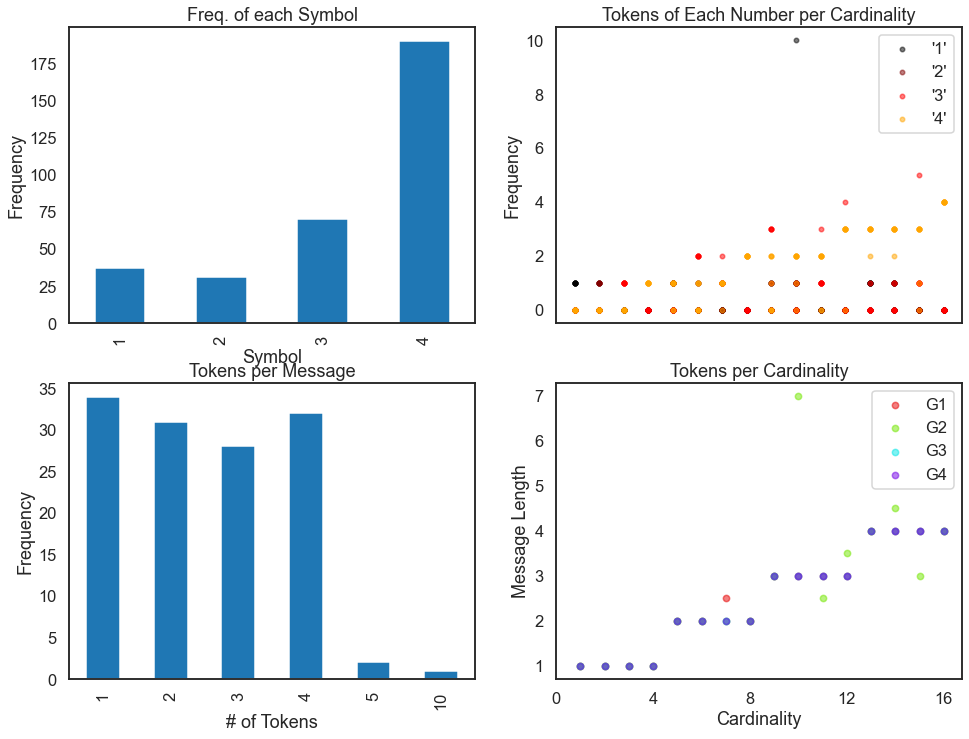

<Figure size 432x288 with 0 Axes>

In [703]:
# get a measure, for each message, of how many of each symbol they used
D[['1']] = D[['symbols']].applymap(lambda x: x.count(1))
D[['2']] = D[['symbols']].applymap(lambda x: x.count(2))
D[['3']] = D[['symbols']].applymap(lambda x: x.count(3))
D[['4']] = D[['symbols']].applymap(lambda x: x.count(4))
D[['messageLength']] = D[['symbols']].applymap(lambda x: len(x))


f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(16,12))
plt.figure()

# now just add up all the symbols that were used across messages and games
D[['1','2','3','4']].sum(axis=0).plot.bar(ax=ax1,title="Freq. of each Symbol",xlabel="Symbol",ylabel='Frequency')

# how many of each number-symbol did different cardinalities use?
D.plot.scatter(ax=ax2,x='cardinality',y='1',c=numColours[1],alpha=.5)
D.plot.scatter(ax=ax2,x='cardinality',y='2',c=numColours[2],alpha=.5)
D.plot.scatter(ax=ax2,x='cardinality',y='3',c=numColours[3],alpha=.5)
D.plot.scatter(ax=ax2,x='cardinality',y='4',c=numColours[4],alpha=.5,
               xticks=[],
               title="Tokens of Each Number per Cardinality",
               xlabel="",
               ylabel='Frequency')
ax2.legend(["'1'","'2'","'3'","'4'"])

# now plot the utterance lengths
D.groupby(['messageLength'])['messageLength'].count().plot.bar(ax=ax3,
                                                               title="Tokens per Message",
                                                               xlabel="# of Tokens",
                                                               ylabel='Frequency')

# for every game, group messages by cardinality and see what their average token length is
for gameid in D.gameID.unique():
    d = pd.DataFrame(D[D['gameID'] == gameid].groupby(['cardinality'])['messageLength'].mean()).reset_index()
    d.plot.scatter(ax=ax4,x='cardinality',y='messageLength',
                   xlabel="Cardinality",ylabel="Message Length",title="Tokens per Cardinality",
                   color=gameColours[gameid],s=40,alpha=.5,xticks=[0,4,8,12,16])
ax4.legend(D.gameID.unique())


<AxesSubplot:title={'center':'4 (clover)'}, xlabel='Cardinality', ylabel='4'>

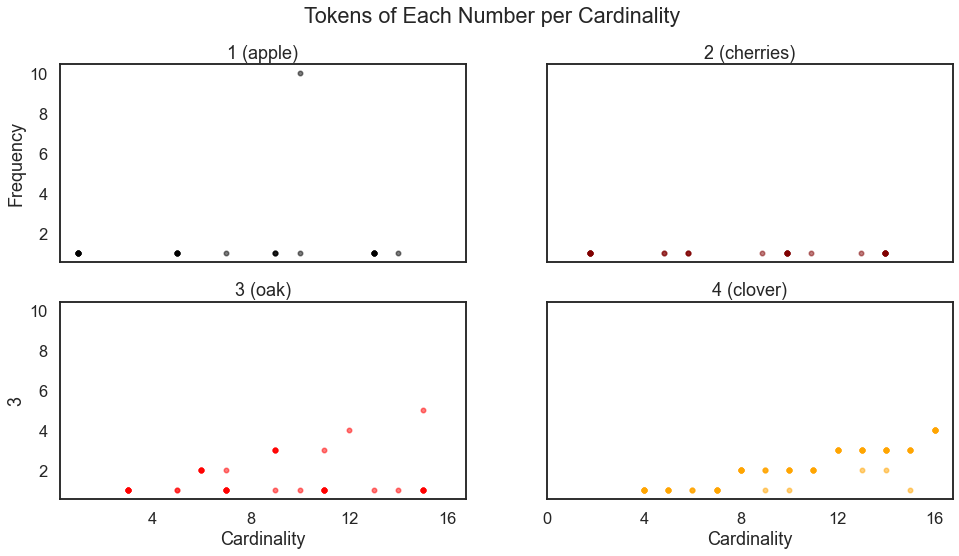

In [704]:
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(16,8),sharex=True,sharey=True)
f.suptitle("Tokens of Each Number per Cardinality")

# how many of each number-symbol did different cardinalities use?
D[D['1']!=0].plot.scatter(ax=ax1,x='cardinality',y='1',c=numColours[1],alpha=.5,ylabel='Frequency',title='1 (apple)')
D[D['2']!=0].plot.scatter(ax=ax2,x='cardinality',y='2',c=numColours[2],alpha=.5,ylabel='Frequency',title='2 (cherries)')
D[D['3']!=0].plot.scatter(ax=ax3,x='cardinality',y='3',c=numColours[3],alpha=.5,xticks=[0,4,8,12,16],xlabel="Cardinality",title='3 (oak)')
D[D['4']!=0].plot.scatter(ax=ax4,x='cardinality',y='4',c=numColours[4],alpha=.5,xticks=[0,4,8,12,16],xlabel="Cardinality",title='4 (clover)')


#### Determinants of Time Taken

Text(0.5, 1.0, 'Trial Durations in each Game')

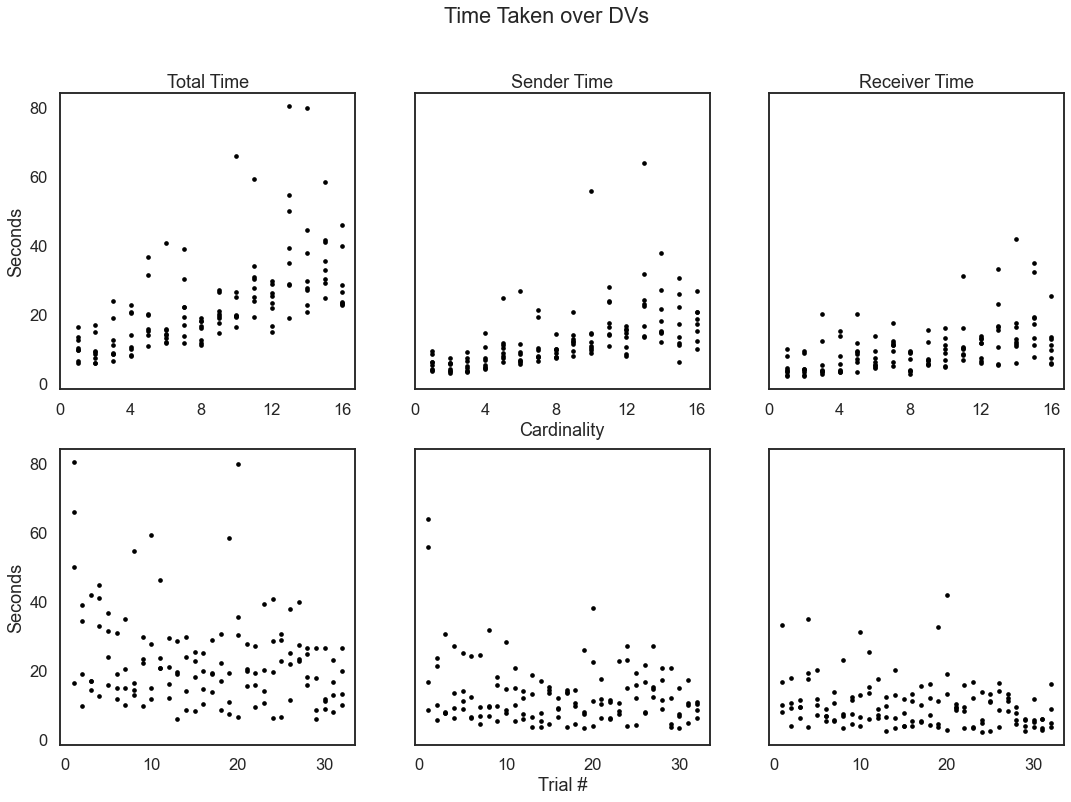

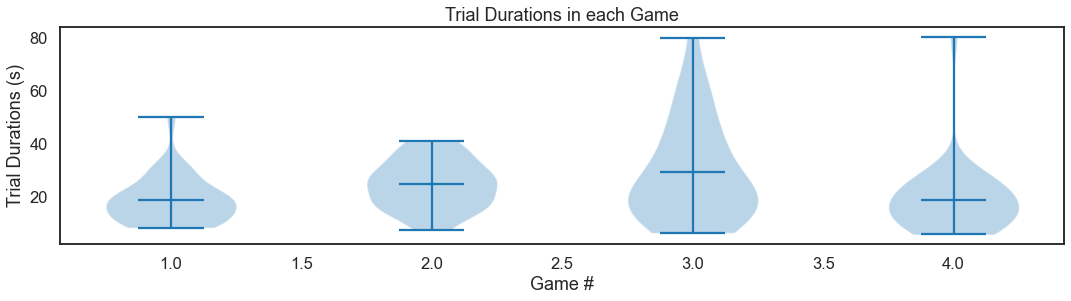

In [705]:
# look at time taken based on cardinality (top row) or trial number (bottom row)
f, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, sharey=True, figsize=(18,12))
f.suptitle("Time Taken over DVs")

# time taken over cardinality
D.plot.scatter(ax=ax1,x='cardinality',y='totalTrialDuration', c='k', s=10,xticks=[0,4,8,12,16],
               xlabel="",ylabel="Seconds",title="Total Time")
D.plot.scatter(ax=ax2,x='cardinality',y='senderTrialDuration', c='k', s=10,xticks=[0,4,8,12,16],
               xlabel="Cardinality",title="Sender Time")
D.plot.scatter(ax=ax3,x='cardinality',y='receiverTrialDuration', c='k', s=10,xticks=[0,4,8,12,16],
               xlabel="",title="Receiver Time")

# time taken over trial number
D.plot.scatter(ax=ax4,x='trialNum',y='totalTrialDuration', c='k', s=10,
               xlabel="",ylabel="Seconds",title="")
D.plot.scatter(ax=ax5,x='trialNum',y='senderTrialDuration', c='k', s=10,
               xlabel="Trial #",title="")
D.plot.scatter(ax=ax6,x='trialNum',y='receiverTrialDuration', c='k', s=10,
               xlabel="",title="")


f, ax7 = plt.subplots(1,1,figsize=(18,4))
# ax7.scatter(D.gameID.unique(),D.groupby(['gameID'])['totalTrialDuration'].mean())
ax7.violinplot([D[D['gameID']==x]["totalTrialDuration"].values for x in D.gameID.unique()],showmeans=True)

ax7.set_xlabel("Game #")
ax7.set_ylabel("Trial Durations (s)")
ax7.set_title("Trial Durations in each Game")


In [706]:
pd.DataFrame(D.groupby(['gameID']).trialNum.max())

,trialNum
gameID,
G1,32
G2,32
G3,32
G4,32


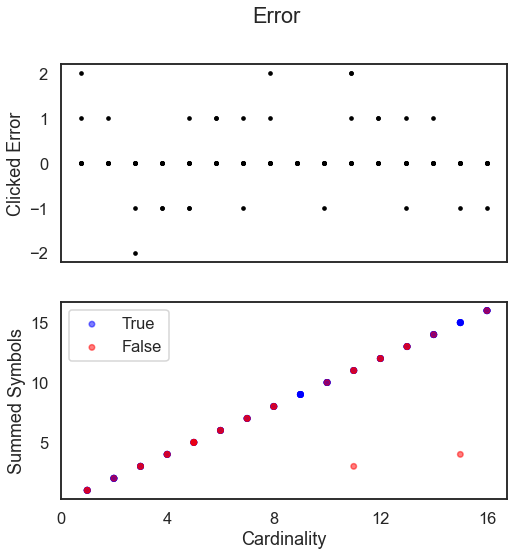

In [715]:
# look to see if the magnitude of errors scaled with cardinality
f, (ax1,ax2) = plt.subplots(2,1, figsize=(8,8), sharex=True)
f.suptitle("Error")

# # clicked error over cardinality
# D.plot.hist(by=['clickedErr'],ax=ax0,
#                ylabel="Clicked Error",xlabel="Error")


# clicked error over cardinality
D.plot.scatter(ax=ax1,x='cardinality',y='clickedErr', c='k', s=10,
               ylabel="Clicked Error",xlabel="Cardinality")

# summed error over cardinality (plot each correctness factor individually so it can be put into legend)
D[D['correct'] == True].plot.scatter(ax=ax2,x='cardinality',y='symbolsSum', s=30,alpha=.5,
                                     c=D[D['correct'] == True]['correct'].map(accColours))
D[D['correct'] == False].plot.scatter(ax=ax2,x='cardinality',y='symbolsSum', s=30,alpha=.5,
                                      c=D[D['correct'] == False]['correct'].map(accColours),
                                      ylabel="Summed Symbols",xlabel="Cardinality",xticks=[0,4,8,12,16])
ax2.legend(['True','False'])



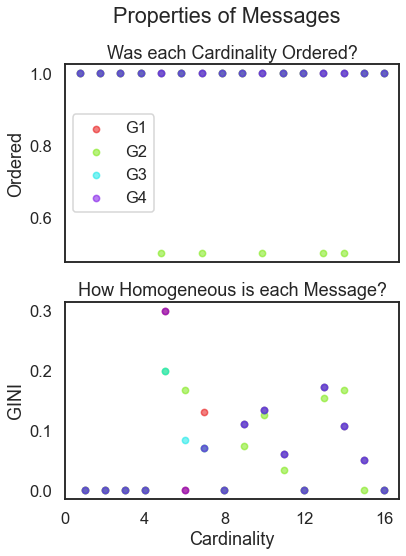

In [708]:
# trying out some different measures of properties of the messages that Senders create
f, (ax1,ax2) = plt.subplots(2,1,figsize=(6,8),sharex=True)
f.suptitle("Properties of Messages")

# plot the average of whether or not symbols in the Sender's message were strictly monotonically decreasing
for gameid in D.gameID.unique():
    d = pd.DataFrame(D[D['gameID'] == gameid].groupby(['cardinality'])['ordered'].mean()).reset_index()
    d.plot.scatter(ax=ax1,x='cardinality',y='ordered',
                   xlabel="",ylabel="Ordered",title="Was each Cardinality Ordered?",
                   color=gameColours[gameid],s=40,alpha=.5)

# plot the GINI coefficient for each message (how heterogeneous is the set of symbols in the message?)
for gameid in D.gameID.unique():
    d = pd.DataFrame(D[D['gameID'] == gameid].groupby(['cardinality'])['gini'].mean()).reset_index()
    d.plot.scatter(ax=ax2,x='cardinality',y='gini',
                   xlabel="Cardinality",ylabel="GINI",title="How Homogeneous is each Message?",
                   color=gameColours[gameid],s=40,alpha=.5,xticks=[0,4,8,12,16])
    
ax1.legend(D.gameID.unique(),loc='center left')

In [673]:
# to make low-level measures:

#  start with non-ordered set based measures
# 2. number of tokens sent for each cardinality (feed into Chrisomalis's measure of a system's smoothness)
# 3. look for a match or mismatch between the target and number of items (see about 1-to-1 correspondence)


# then look at sequence (which symbols come before or after which ones in the message)

# do some repetition analysis, trial number; see if we really need to be doing repetitions



In [722]:
text = "body=Dear%20Clerk%20of%20the%20Board%20and%20SANDAG%20Board%20Chairs%2C%0D%0A%0D%0AThank%20you%20for%20the%20opportunity%20to%20provide%20comment%20in%20support%20of%20the%202021%20Regional%20Plan%2C%20which%20will%20shape%20our%20region%20for%20decades%20to%20come.%0D%0A%0D%0AI%20support%20this%20plan%20because%20this%20is%20San%20Diego’s%20first%20ever%20transit-first%20plan%2C%20with%20strong%20commitments%20to%20transportation%20and%20environmental%20justice%2C%20such%20as%20better%20access%20to%20job%20centers%2C%20safer%20streets%2C%20new%20and%20improved%20rail%20and%20buses%2C%20protected%20bike%20lanes%2C%20and%20free%20transit%20by%202030.%20This%20plan%20is%20consistent%20with%20state%20climate%20law%2C%20and%20puts%20our%20region%20on%20the%20path%20to%20slashing%20transportation%20emissions.%0D%0A%0D%0AEach%20piece%20of%20the%20plan%2C%20as-drafted%2C%20is%20crucial.%20We%20must%20leave%20all%20future%20revenue%20sources%20on%20the%20table%20if%20we%20hope%20to%20realize%20the%20vision%20of%20an%20equitable%2C%20world-class%20transportation%20system%20or%20we%27ll%20be%20out%20of%20compliance%20with%20state%20climate%20law%20and%20lose%20out%20on%20billions%20of%20dollars%20in%20potential%20funding%20from%20the%20state%20and%20federal%20governments.%0D%0A%0D%0AThis%20is%20the%20best%20Regional%20Plan%20San%20Diego%20has%20ever%20seen%2C%20and%20we%20urge%20you%20to%20support%20it%20unanimously%2C%20as-drafted%2C%20today—with%20no%20changes%20to%20the%20plan’s%20funding%20strategy!%20Thank%20you.%0D%0A"    
text = text.replace("%20"," ").replace("%0A"," \n\n ")
print(text)

body=Dear Clerk of the Board and SANDAG Board Chairs%2C%0D 

 %0D 

 Thank you for the opportunity to provide comment in support of the 2021 Regional Plan%2C which will shape our region for decades to come.%0D 

 %0D 

 I support this plan because this is San Diego’s first ever transit-first plan%2C with strong commitments to transportation and environmental justice%2C such as better access to job centers%2C safer streets%2C new and improved rail and buses%2C protected bike lanes%2C and free transit by 2030. This plan is consistent with state climate law%2C and puts our region on the path to slashing transportation emissions.%0D 

 %0D 

 Each piece of the plan%2C as-drafted%2C is crucial. We must leave all future revenue sources on the table if we hope to realize the vision of an equitable%2C world-class transportation system or we%27ll be out of compliance with state climate law and lose out on billions of dollars in potential funding from the state and federal governments.%0D 

 %0D

In [674]:
P = P.astype({'totalTime':int})
(P.totalTime / 1000 / 60).median()

16.115466666666666

In [682]:
for player,comment in enumerate(P['comments']):
    print(P['prolificID'][player]," : ",''.join(map(str, comment)))

6109cc79ac866ff8a2e5a1af  :  My partner never responded which bothered me because the game seemed fun
5b58d3b23732c20001e6d097  :  
60901990415b22dac0b91f3c  :  
616af649d4bc6cd939f76f90  :  None
5fa162ba8b73e4242141ca82  :  
6144dd4c785eb111a10ad286  :  
5ffd82a2cecb152c32eb051a  :  it was very interesting
60f6c72883707485e6765e47  :  
